In [3]:
import pickle
import re
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import fuzzywuzzy
from fuzzywuzzy import process

import warnings
warnings.filterwarnings('ignore')

import clean

/home/kieran/Downloads/Software/miniconda3/lib/python3.7/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [4]:
with open("./data/file_list", "rb") as fp:
    b = pickle.load(fp)
surveys = [x for x in b if 'Metadata' not in x]

site_name = 'lulli'
site_files = []
for file_name in surveys:
    if site_name.lower() in file_name.lower():
        site_files.append(file_name)

for ss in site_files:
    print(ss)

data/Lullington_Heath_NNR_/Long_term_monitoring_network_vegetation_survey_Lullington_Heath_NNR_2018.xlsx
data/Lullington_Heath_NNR_/Long_term_monitoring_network_vegetation_survey_Lullington_Heath_NNR_2014.xlsx
data/Lullington_Heath_NNR_/Long_term_monitoring_network_vegetation_survey_Lullington_Heath_NNR_2011.xlsx


In [5]:
data = []
for site in site_files:
    xls = pd.ExcelFile(site)

    for name in xls.sheet_names:
        if 'whole' in name.lower():
            wpd_string = name
        if 'species te' in name.lower():
            spec_temp_string = name
        if 'ground' in name.lower():
            ground_string = name

    whole = xls.parse(wpd_string)
    whole = clean.whole_clean(whole)

    species = xls.parse(spec_temp_string)
    species = clean.species_clean(species)
    cover, frequency = clean.get_abund_and_freq(species, column='desc_latin')

    ground = xls.parse(ground_string)
    ground = clean.ground_clean(ground)

    ####################################################################
    # extracting the useful information
    ####################################################################

    df = pd.DataFrame()

    year = whole['year'][0].astype(str)

    df['year'] = whole['year']
    df['bap_b'] = whole['bap_broad']
    df['bap_p'] = whole['bap_priority']
    df['freq_count'] = frequency.gt(0).sum(axis=1)
    df['max_height'] = ground['max_height']
    df['median_height'] = ground['median_height']
    df['freq-bare soil'] = ground['freq-bare soil']
    data.append(df)
    
print('whole\n')
print(whole.head())
print('\ncover\n')
print(cover.head())
print('\nground\n')
print(ground.head())

whole

           sitecode mcode  year plot_id  eastings  northings  altitude  \
index_id                                                                 
1_B14_2011      B14    VC  2011       1    554317     101738      89.0   
2_B14_2011      B14    VC  2011       2    554339     101572     110.0   
3_B14_2011      B14    VC  2011       3    554950     101564     124.0   
4_B14_2011      B14    VC  2011       4    554867     101469     104.0   
5_B14_2011      B14    VC  2011       5    554302     101665     109.0   

            landuse_code  slope  aspect  ...   ph  fertility  \
index_id                                 ...                   
1_B14_2011          16.0    0.0   210.0  ...  5.5        4.4   
2_B14_2011          16.0    9.0   280.0  ...  6.1        4.5   
3_B14_2011          16.0   10.0   270.0  ...  5.6        3.4   
4_B14_2011          16.0    4.0   275.0  ...  5.8        3.7   
5_B14_2011          16.0    4.0   220.0  ...  5.8        4.7   

            ellenburg_no 

In [7]:
n_sites = len(data)
data2 = data[::-1]
total_data = pd.concat(data2)

print('number of surveys - ', n_sites, '\n')
print(total_data.head())

number of surveys -  3 

            year                 bap_b               bap_p  freq_count  \
index_id                                                                 
1_B14_2011  2011  Calcareous grassland  Lowland calcareous        10.0   
2_B14_2011  2011  Calcareous grassland  Lowland calcareous        32.0   
3_B14_2011  2011  Calcareous grassland  Lowland calcareous        28.0   
4_B14_2011  2011  Calcareous grassland  Lowland calcareous        35.0   
5_B14_2011  2011  Calcareous grassland  Lowland calcareous        26.0   

            max_height  median_height  freq-bare soil  
index_id                                               
1_B14_2011        22.0           13.0             0.0  
2_B14_2011        32.0            7.5             1.0  
3_B14_2011         3.5            2.0             0.0  
4_B14_2011         3.5            2.0             0.0  
5_B14_2011        16.0            8.0             1.0  


In [8]:
def check_names(list_of_names, min_ratio = 90):

    print('\nchecking for typos\n')
    for pp in list_of_names:
        matches = fuzzywuzzy.process.extract(pp, list_of_names, limit=2, scorer=fuzzywuzzy.fuzz.token_sort_ratio)
        if matches[1][1] > min_ratio:
            print(pp, ' - ', matches)

def replace_matches_in_column(df, column, string_to_match, min_ratio = 90):
    # get a list of unique strings
    strings = df[column].unique()

    # get the top 10 closest matches to our input string
    matches = fuzzywuzzy.process.extract(string_to_match, strings,
                                         limit=10, scorer=fuzzywuzzy.fuzz.token_sort_ratio)

    # only get matches with a ratio > 90
    close_matches = [matches[0] for matches in matches if matches[1] >= min_ratio]

    # get the rows of all the close matches in our dataframe
    rows_with_matches = df[column].isin(close_matches)

    # replace all rows with close matches with the input matches
    df.loc[rows_with_matches, column] = string_to_match

    
total_data = total_data[total_data['bap_b'].notna()]
total_data['bap_b'] = total_data['bap_b'].str.lower()

names = total_data['bap_b'].unique()
print('list of unique names in bap_b\n')
print(names)
names = [x for x in names if str(x) != 'nan']
check_names(names, min_ratio = 80)

#replace_matches_in_column(total_data, 'bap_b', 'fen, marsh and swamp', min_ratio = 80)
#replace_matches_in_column(total_data, 'bap_b', 'supralittoral sediment')

bap_b = total_data['bap_b'].unique()
fig_num = len(bap_b)

list of unique names in bap_b

['calcareous grassland' 'dwarf shrub heath' 'scrub'
 'broadleaved, mixed and yew woodland']

checking for typos



__supralitoral sediment__ is converted to __supralittoral sediment__ and __fen marsh or swamp__ is converted to __fen, marsh and swamp__

In [9]:
years = total_data['year'].unique()
for yy in years:
    df = total_data[total_data['year'] == yy]
    print('\n', yy, '\n')
    print(df['bap_b'].value_counts())


 2011 

calcareous grassland                   36
dwarf shrub heath                       6
scrub                                   5
broadleaved, mixed and yew woodland     3
Name: bap_b, dtype: int64

 2014 

calcareous grassland                   36
dwarf shrub heath                       6
scrub                                   5
broadleaved, mixed and yew woodland     3
Name: bap_b, dtype: int64

 2018 

calcareous grassland    23
dwarf shrub heath        5
Name: bap_b, dtype: int64


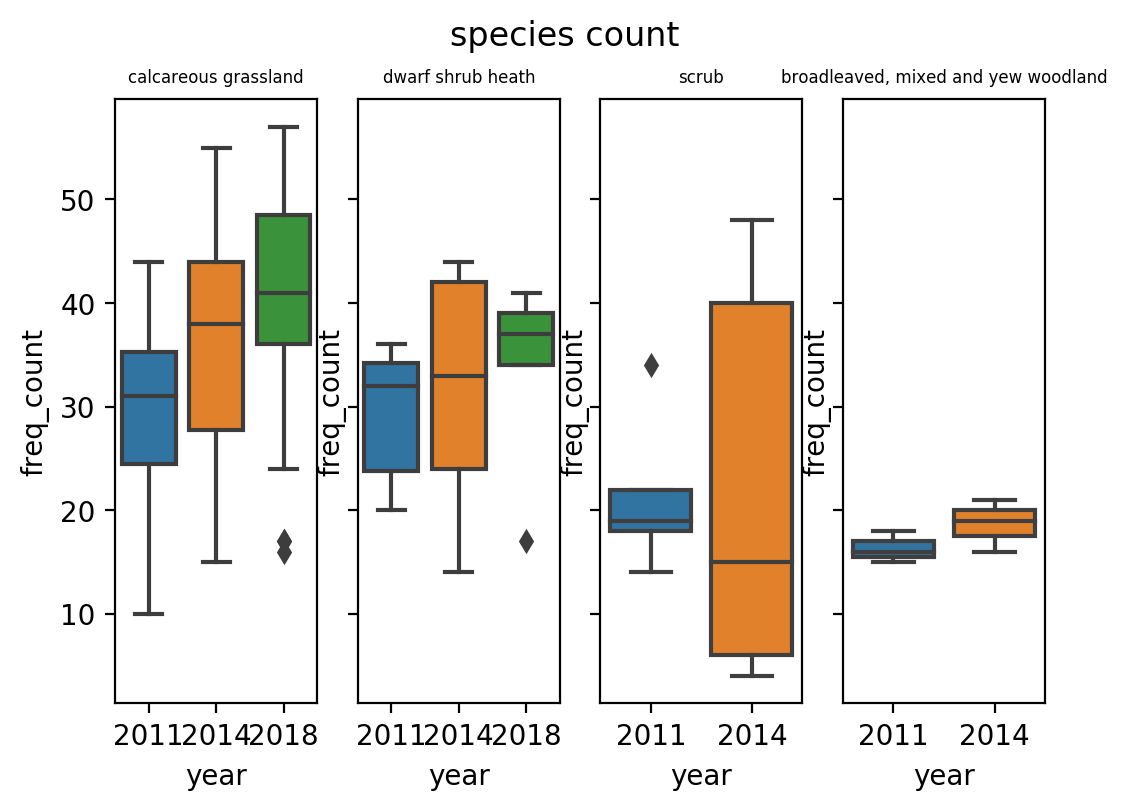

In [10]:
fig, axes = plt.subplots(ncols=fig_num, sharey=True, dpi=200)
fig.suptitle('species count')
for i, ax in zip(range(10), axes.flat):
    sns.boxplot(data = total_data[total_data['bap_b'] == bap_b[i]],
        x='year', y='freq_count', ax=ax).set_title(bap_b[i], fontsize=6)
plt.show()

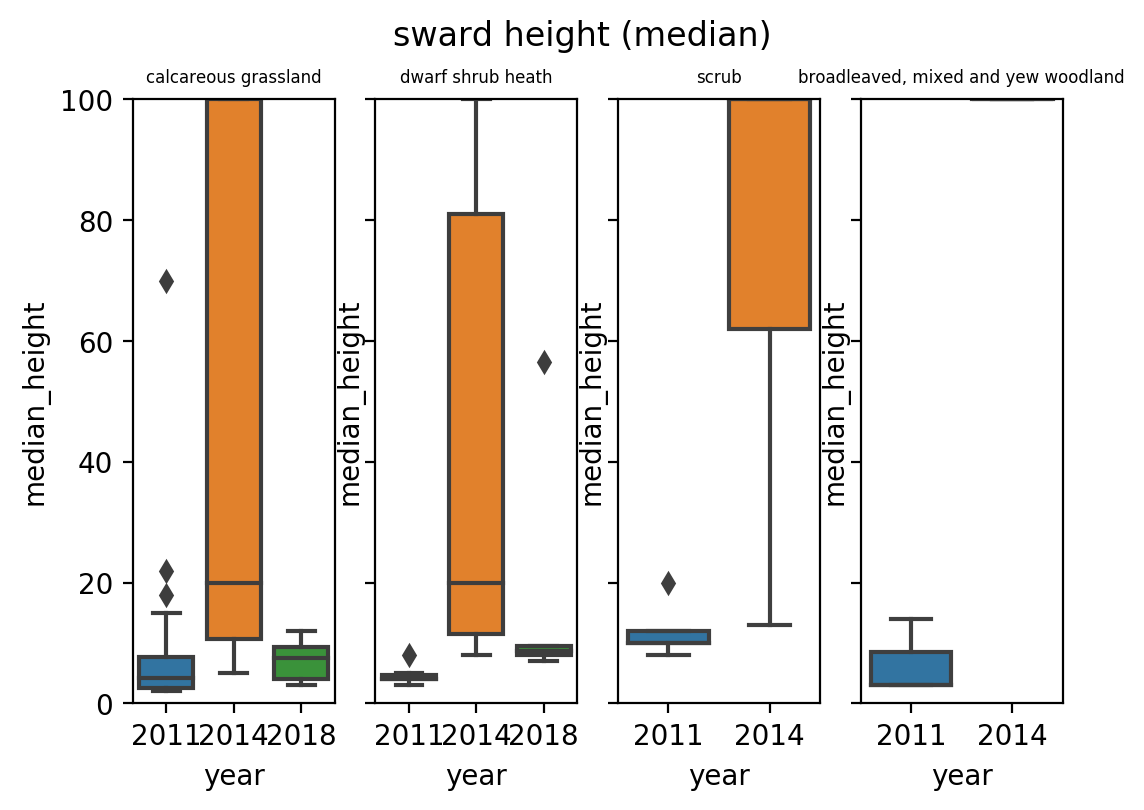

In [11]:
fig, axes = plt.subplots(ncols=fig_num, sharey=True, dpi=200)
fig.suptitle('sward height (median)')
for i, ax in zip(range(10), axes.flat):
    sns.boxplot(data = total_data[total_data['bap_b'] == bap_b[i]],
        x='year', y='median_height', ax=ax).set_title(bap_b[i], fontsize=6)
    ax.set(ylim=(0, 100))
plt.show()